## Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks price data
* Calculate different features and indicators on each stock
* Aggregate on monthly level and filter top 150 most liquid stocks
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustring Algorithm to group simular assets based on their features.
* For each month select assets based on the cluster and form a portfolio on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns

### 1 Download/Load SP500 stocks price data

In [115]:
from statsmodels.regression.rolling import RollingOLS

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [116]:
sp500           = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0] # import data
sp500['Symbol'] = sp500['Symbol'].str.replace(".", "-") # clean data 

symbols_list    = sp500['Symbol'].unique().tolist() #notice:these stock names are not survivor-bias free

end_date        = '2023-09-27'
start_date      = pd.to_datetime(end_date) - pd.DateOffset(365*8) #use 8 years data

df              = yf.download(tickers=symbols_list, start = start_date, end = end_date).stack()




[*********************100%%**********************]  503 of 503 completed


1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


In [117]:
df

Adj Close       Close        High         Low        Open  \
Date                                                                          
2015-09-29 A      31.534704   33.740002   34.060001   33.240002   33.360001   
           AAL    37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL   24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV   36.674229   52.790001   54.189999   51.880001   53.099998   
           ABT    33.644733   39.500000   40.150002   39.029999   39.259998   
...                     ...         ...         ...         ...         ...   
2023-09-26 XYL    88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM   122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH   111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA  223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS   176.048248  176.869995  178.449997  176.270004  176.580002   

                      Volume  
Date                          
2015-09-29 A       2252400.0  
           AAL     7478800.0  
           AAPL  293461600.0  
           ABBV   12842800.0  
           ABT    12287500.0  
...                      ...  
2023-09-26 XYL     1322400.0  
           YUM     1500600.0  
           ZBH     3610500.0  
           ZBRA     355400.0  
           ZTS     1463200.0  

[993179 rows x 6 columns]

In [118]:
df.index.names = ['date','ticker']
df.columns     = df.columns.str.lower()
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534704   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.674229   52.790001   54.189999   51.880001   53.099998   
           ABT      33.644733   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     176.048248  176.869995  178.449997  176.270004  176.580002   

                        volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[993179 rows x 6 columns]

### 2 Calculate features and technical indicators for each stock

* Garman - Klass Volatility: a meansure of intra-day volatility

$$Garman-Klass Volatility = \frac{(ln(High)-ln(Low))^2}{2} - (2ln(2)-1)*(ln(Adj Close) - ln(Open))^2$$

* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [119]:
# Generate Garman Klass Volatility column
df["garman_klass_vol"] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# Generate RSI column
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Generate Bollinger Bands: low, middle, and high
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# Generate ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low  = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Generate MCAD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# Generate dollar volumn
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534704   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.674229   52.790001   54.189999   51.880001   53.099998   
           ABT      33.644733   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     176.048248  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000926        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005572        NaN       NaN   
           ABBV     12842800.0         -0.051964        NaN       NaN   
           ABT      12287500.0         -0.008803        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000016  26.146743  4.488345   
           YUM       1500600.0          0.000002  36.057149  4.816569   
           ZBH       3610500.0          0.000161  31.893253  4.749948   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000072  42.623479  5.158939   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      71.028768  
           AAL          NaN       NaN       NaN       NaN     279.420069  
           AAPL         NaN       NaN       NaN       NaN    7243.972939  
           ABBV         NaN       NaN       NaN       NaN     470.999784  
           ABT          NaN       NaN       NaN       NaN     413.409662  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.570270  4.652196  0.033800 -2.159188     117.651922  
           YUM     4.846536  4.876502  0.142547 -1.363695     184.291052  
           ZBH     4.789615  4.829283 -0.381708 -0.881067     404.350437  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.217753  5.276568  0.651515 -1.188278     257.593797  

[993179 rows x 14 columns]

<AxesSubplot: xlabel='date'>

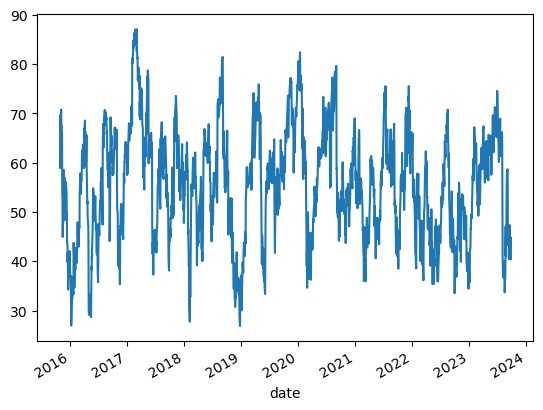

In [120]:
df.xs('AAPL',level=1)['rsi'].plot()

### 3 Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.


In [128]:
# Define the last columns
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume','open',
                                                         'high','low','close']]

data=(pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                 df.unstack()[last_cols].resample('M').last().stack('ticker')],
                 axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2015-11-30 A          136.213760   39.086582 -1.033887  3.692471  3.547568   
           AAL        287.915787   39.429928  0.190822  3.827636  3.672028   
           AAPL      4029.441881   26.890560 -0.967900  3.369611  3.282983   
           ABBV       340.716445   40.770771 -0.526809  3.832284  3.735768   
           ABT        212.708765   38.483482 -1.064842  3.704588  3.660875   
...                          ...         ...       ...       ...       ...   
2023-09-30 OTIS       154.983158   78.671936 -1.028320  4.464683  4.374104   
           ABNB      1633.500725  132.279999 -1.006939  5.024801  4.857047   
           CEG        196.971017  108.026909 -0.436215  4.734007  4.653660   
           GEHC       212.350629   66.153511 -0.893478  4.270855  4.155782   
           KVUE       677.910279   20.218124 -0.899746  3.174263  3.024299   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2015-11-30 A       3.620020         -0.001902  0.567157  73.421452  
           AAL     3.749832         -0.000966 -0.418773  40.718953  
           AAPL    3.326297         -0.003209 -0.142790  55.537331  
           ABBV    3.784026         -0.056745  0.145678  49.376887  
           ABT     3.682732         -0.010572  0.335557  56.962486  
...                     ...               ...       ...        ...  
2023-09-30 OTIS    4.419394         -0.000020 -1.534536  33.116222  
           ABNB    4.940924          0.000213 -0.037854  44.494127  
           CEG     4.693834          0.000171  0.366876  55.245465  
           GEHC    4.213319          0.000185 -1.116463  40.922335  
           KVUE    3.099281          0.000032 -1.435620  35.706315  

[46894 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering

In [129]:
data['dollar_volume'] = (data['dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume','dollar_vol_rank'],axis=1)
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2020-10-31 AAL      11.280000 -1.244464  2.700490  2.483765  2.592127   
           AAPL    106.650467  1.409489  4.805040  4.687402  4.746221   
           ABBV     74.413948 -0.194581  4.361750  4.274955  4.318352   
           ABT      99.325333  0.983090  4.660720  4.606050  4.633385   
           ACN     207.315063  0.515540  5.424471  5.326401  5.375436   
...                       ...       ...       ...       ...       ...   
2023-09-30 VRTX    351.690002  0.029799  5.879295  5.838959  5.859127   
           VZ       31.764891 -1.078816  3.547598  3.483152  3.515375   
           WFC      40.009789 -0.558742  3.783384  3.702645  3.743015   
           WMT      53.783062 -0.196381  4.023309  3.988367  4.005838   
           XOM     114.292953  0.601335  4.775304  4.695106  4.735205   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2020-10-31 AAL             0.000622 -0.348861  41.027057  
           AAPL            0.000122 -0.628203  43.770313  
           ABBV           -0.004122 -0.994068  47.517628  
           ABT            -0.000827 -0.069482  48.047162  
           ACN            -0.000362 -0.949113  42.280831  
...                             ...       ...        ...  
2023-09-30 VRTX            0.000037  0.027907  52.406728  
           VZ             -0.000408 -0.350386  42.222480  
           WFC             0.000016 -0.282325  40.920288  
           WMT            -0.000011  0.399459  54.722559  
           XOM             0.000026  1.400623  59.440178  

[5364 rows x 8 columns]

### 4 Calculate Monthly Returns for different time horizons as features

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historial returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [130]:
g = df.xs('AAPL', level=1)

def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                                  .pct_change(lag)
                                  .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                         upper=x.quantile(1-outlier_cutoff)))
                                  .add(1)
                                  .pow(1/lag)
                                  .sub(1))
    return df

data = data.groupby(level=1, group_keys = False).apply(calculate_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2021-10-31 AAL      19.200001 -1.220376  3.100231  2.974729  3.037480   
           AAPL    147.703445  0.472670  5.025756  4.922491  4.974124   
           ABBV    105.080338 -0.296892  4.640553  4.584204  4.612378   
           ABT     123.679230  0.548868  4.842667  4.679497  4.761082   
           ACN     347.157745  0.369751  5.877819  5.719036  5.798428   
...                       ...       ...       ...       ...       ...   
2023-09-30 VRTX    351.690002  0.029799  5.879295  5.838959  5.859127   
           VZ       31.764891 -1.078816  3.547598  3.483152  3.515375   
           WFC      40.009789 -0.558742  3.783384  3.702645  3.743015   
           WMT      53.783062 -0.196381  4.023309  3.988367  4.005838   
           XOM     114.292953  0.601335  4.775304  4.695106  4.735205   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2021-10-31 AAL             0.000261 -0.271008  44.082954  -0.064327   
           AAPL            0.000280  0.401624  55.907758   0.058657   
           ABBV           -0.001133  0.079690  62.750385   0.075926   
           ABT            -0.000169  1.377108  65.824291   0.095299   
           ACN            -0.000053  1.724871  67.655717   0.124829   
...                             ...       ...        ...        ...   
2023-09-30 VRTX            0.000037  0.027907  52.406728   0.009617   
           VZ             -0.000408 -0.350386  42.222480  -0.056890   
           WFC             0.000016 -0.282325  40.920288  -0.015500   
           WMT            -0.000011  0.399459  54.722559  -0.000676   
           XOM             0.000026  1.400623  59.440178   0.046947   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2021-10-31 AAL     -0.018731  -0.019685  -0.020344   0.012494    0.043614  
           AAPL    -0.006708   0.009428   0.022549   0.014717    0.027509  
           ABBV    -0.019734  -0.000688   0.008565   0.016537    0.029174  
           ABT      0.011869   0.022649   0.013162   0.005941    0.018442  
           ACN      0.034029   0.042428   0.037130   0.045796    0.043491  
...                      ...        ...        ...        ...         ...  
2023-09-30 VRTX    -0.000923  -0.000208   0.018495   0.022140    0.016337  
           VZ      -0.016122  -0.033458  -0.021495  -0.014100   -0.006158  
           WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255  
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  

[3441 rows x 14 columns]

### 5 Download Fama-French Factors and Calculate Rolling Factor Betas

* We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression
* The five Fama-French factors, namely "Market Riskj", "Size", "Value", "Operating Profitability", and "Investment" have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. hence, it is natural to include past factor exposures as financial features in modles.
* We can access the historical factor returns using the pandas-datareader and estimate histoprical exposures using the RollingOLS rolling linear regression.

In [133]:
factor_data = web.DataReader('F-F_research_Data_5_Factors_2x3',
                              'famafrench',
                              start='2010')[0].drop('RF',axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data

#join this data to month return

factor_data = factor_data.join(data['return_1m']).sort_index()

# double check with apple and microsoft as example
factor_data.xs('AAPL',level=1).head()


,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2021-10-31,0.0665,-0.0270,-0.0049,0.0166,-0.0145,0.058657
2021-11-30,-0.0155,-0.0177,-0.0045,0.0720,0.0173,0.105082
2021-12-31,0.0310,-0.0080,0.0326,0.0491,0.0440,0.074229
2022-01-31,-0.0625,-0.0406,0.1275,0.0084,0.0772,-0.015712
2022-02-28,-0.0229,0.0292,0.0308,-0.0209,0.0312,-0.054066


In [134]:
factor_data.xs('MSFT',level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2021-10-31,0.0665,-0.0270,-0.0049,0.0166,-0.0145,0.172821
2021-11-30,-0.0155,-0.0177,-0.0045,0.0720,0.0173,-0.001282
2021-12-31,0.0310,-0.0080,0.0326,0.0491,0.0440,0.017333
2022-01-31,-0.0625,-0.0406,0.1275,0.0084,0.0772,-0.075345
2022-02-28,-0.0229,0.0292,0.0308,-0.0209,0.0312,-0.037212
